In [ ]:
from experiments.planck.plite import PlanckLitePy
import camb
import numpy as np
import os
import math
import pickle
import numpy as np
import matplotlib.pylab as plt
from getdist import plots, MCSamples
import pandas as pd
import scipy.stats as ss
import emcee
from torchemu.gaussianprocess import GaussianProcess
from configs.configPlanck import get_config
import torch

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
contours = [0.68, 0.95]
linewidth = 2

In [3]:
NLHS = 2000
NDIM = 6
NTEST = 1000
NSTD = 8
USE_GP = True
UNIFORM_PRIOR = False
NCOV = 2.0

# Reference

<img src="src/emulike/planck/images/priors.png" width=1000 />

<img src="src/emulike/planck/images/planck_2018.png" width=1000 />

<img src="src/emulike/planck/images/from_paper.png" width=1000 />

In [4]:
np.exp(2.7) * 1e-10

1.4879731724872838e-09

In [5]:
np.exp(4) * 1e-10

5.459815003314424e-09

# Planck Lite

In [6]:
TT2018 = PlanckLitePy(
    data_directory="experiments/planck/data",
    year=2018,
    spectra="TT",
    use_low_ell_bins=False,
)

In [7]:
ls, Dltt, Dlte, Dlee = np.genfromtxt(
    "experiments/planck/data/Dl_planck2015fit.dat", unpack=True
)
ellmin = int(ls[0])

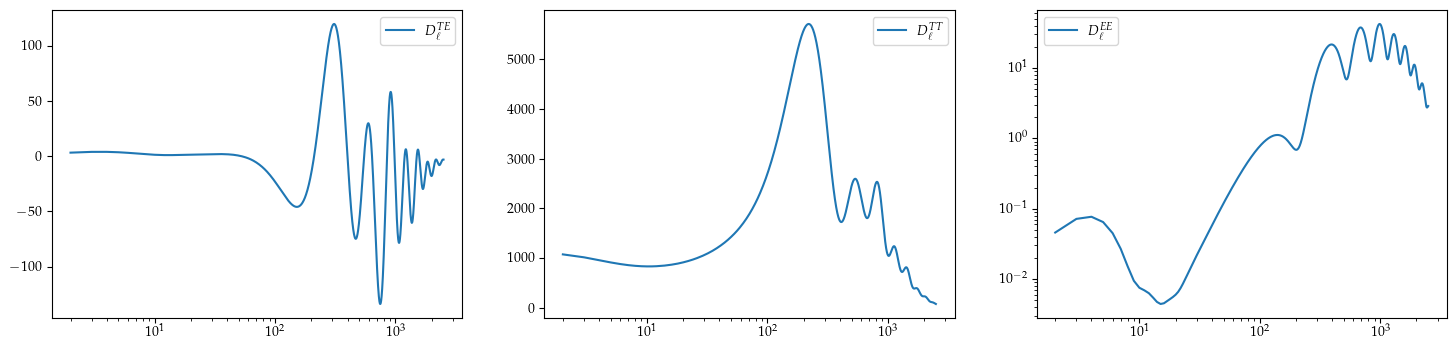

In [8]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(ls, Dlte, label=r"$D_{\ell}^{TE}$")
plt.xscale("log")
plt.legend()
plt.subplot(132)
plt.plot(ls, Dltt, label=r"$D_{\ell}^{TT}$")
plt.xscale("log")
plt.legend()
plt.subplot(133)
plt.loglog(ls, Dlee, label=r"$D_{\ell}^{EE}$")
plt.legend()
plt.show()

In [9]:
expected = -101.58123068722583
loglike = TT2018.loglike(Dltt, Dlte, Dlee, ellmin)
print("Planck-lite-py log likelihood:", loglike)
print("Expected log likelihood:", expected)
print("Difference:", loglike - expected, "\n\n")

Planck-lite-py log likelihood: -101.58123068722583
Expected log likelihood: -101.58123068722583
Difference: 0.0 




In [10]:
TTTEEE2018_lowTTbins = PlanckLitePy(
    data_directory="experiments/planck/data",
    year=2018,
    spectra="TTTEEE",
    use_low_ell_bins=True,
)

# call the likelihood function
loglike = TTTEEE2018_lowTTbins.loglike(
    Dltt, Dlte, Dlee, ellmin
)  # ellmin = 2 by default
expected = -293.95586501795134
print("Planck-lite-py likelihood:", loglike)
print("Expected log likelihood:", expected)
print("Difference:", loglike - expected, "\n\n")

Planck-lite-py likelihood: -293.95586501795134
Expected log likelihood: -293.95586501795134
Difference: 0.0 




# CAMB

Use CAMB rather than CLASS to build the emulator.

In [9]:
# Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
pars.set_cosmology(
    ombh2=0.0223828, omch2=0.1201075, mnu=0.06, omk=0, tau=0.054, thetastar=1.0446 / 100
)
# pars.set_cosmology(H0=67.32117, ombh2=0.0223828, omch2=0.1201075, mnu=0.06, omk=0, tau=0.054)
pars.InitPower.set_params(As=2.100549e-9, ns=0.9660499)
pars.set_for_lmax(2508, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

In [10]:
# Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
# The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
camb_tt = powers["unlensed_scalar"][:, 0]
camb_ee = powers["unlensed_scalar"][:, 1]
camb_bb = powers["unlensed_scalar"][:, 2]
camb_te = powers["unlensed_scalar"][:, 3]

ls = np.arange(camb_tt.shape[0])

condition_1 = (ls >= 2) & (ls <= 2508)

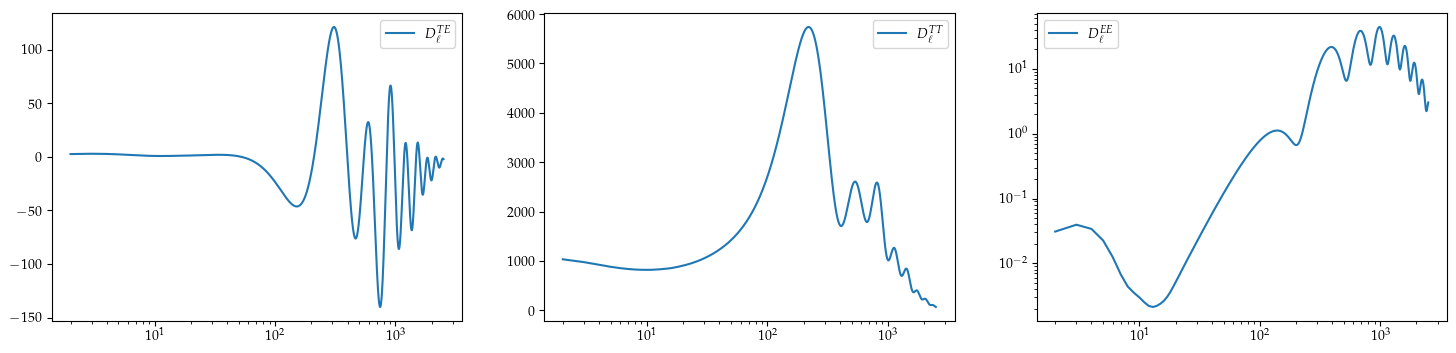

In [11]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(ls[condition_1], camb_te[condition_1], label=r"$D_{\ell}^{TE}$")
plt.xscale("log")
plt.legend()
plt.subplot(132)
plt.plot(ls[condition_1], camb_tt[condition_1], label=r"$D_{\ell}^{TT}$")
plt.xscale("log")
plt.legend()
plt.subplot(133)
plt.loglog(ls[condition_1], camb_ee[condition_1], label=r"$D_{\ell}^{EE}$")
plt.legend()
plt.show()

In [12]:
TT2018.loglike(camb_tt[condition_1], camb_te[condition_1], camb_ee[condition_1], ellmin)

-371.7616827109076

Other tests

In [13]:
TTTEEE2018_lowTTbins = PlanckLitePy(
    data_directory="experiments/planck/data",
    year=2018,
    spectra="TTTEEE",
    use_low_ell_bins=True,
)

In [14]:
# call the likelihood function
loglike = TTTEEE2018_lowTTbins.loglike(Dltt, Dlte, Dlee, ellmin)

In [15]:
loglike

-293.95586501795134

In [16]:
TTTEEE2018_lowTTbins.loglike(
    camb_tt[condition_1], camb_te[condition_1], camb_ee[condition_1], ellmin
)

-691.5977164644581

# Public Planck 2018 Results

In [15]:
folder = "/home/harry/Desktop/Planck/base/plikHM_TTTEEE_lowl_lowE/"

c1 = np.loadtxt(folder + "base_plikHM_TTTEEE_lowl_lowE_1.txt")
c2 = np.loadtxt(folder + "base_plikHM_TTTEEE_lowl_lowE_2.txt")
c3 = np.loadtxt(folder + "base_plikHM_TTTEEE_lowl_lowE_3.txt")
c4 = np.loadtxt(folder + "base_plikHM_TTTEEE_lowl_lowE_4.txt")
# 0 omegabh2	\Omega_b h^2
# 1 omegach2	\Omega_c h^2
# 2 theta	100\theta_{MC}
# 3 tau	\tau
# 4 logA	{\rm{ln}}(10^{10} A_s)
# 5 ns	n_s
# 28 H0*	H_0

In [17]:
# indices = [0, 1, 2, 3, 4, 5]
# cosmoparams_1 = c1[:,2:][:,indices]
# cosmoparams_2 = c2[:,2:][:,indices]
# cosmoparams_3 = c3[:,2:][:,indices]
# cosmoparams_4 = c4[:,2:][:,indices]

# cosmoparams = np.concatenate([cosmoparams_1, cosmoparams_2, cosmoparams_3, cosmoparams_4], axis = 0)

# mean = np.mean(cosmoparams, axis = 0)
# std = np.std(cosmoparams, axis = 0)
# cov = np.cov(cosmoparams.T)

# Samples from CAMB Run

In [145]:
camb_samples_1 = np.loadtxt("samples/camb_samples_1.txt")
camb_samples_2 = np.loadtxt("samples/camb_samples_2.txt")

In [147]:
np.mean(camb_samples_1, axis=0)

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [148]:
np.mean(camb_samples_2, axis=0)

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [151]:
np.std(camb_samples_1, axis=0) * 1000

array([0.103, 1.040, 0.218, 11.043, 22.321, 3.018])

In [152]:
np.std(camb_samples_2, axis=0) * 1000

array([0.102, 1.051, 0.220, 11.112, 22.331, 3.026])

In [155]:
camb_samples_comb = np.vstack([camb_samples_1, camb_samples_2])

In [262]:
np.max(camb_samples_comb, axis=0)

array([0.022, 0.127, 1.042, 0.106, 3.141, 0.970])

In [215]:
mean = np.mean(camb_samples_comb, axis=0)

In [267]:
mean

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [159]:
np.std(camb_samples_comb, axis=0) * 1000

array([0.103, 1.046, 0.219, 11.078, 22.327, 3.022])

In [265]:
cov = np.cov(camb_samples_comb.T)

In [266]:
cov * 1e8

array([[1.055, -6.475, 0.714, -7.161, -25.732, 12.121],
       [-6.475, 109.395, -8.132, 45.595, 353.407, -228.510],
       [0.714, -8.132, 4.795, -42.917, -101.820, 20.752],
       [-7.161, 45.595, -42.917, 12272.618, 24524.043, 386.078],
       [-25.732, 353.407, -101.820, 24524.043, 49851.000, 129.898],
       [12.121, -228.510, 20.752, 386.078, 129.898, 913.289]])

In [269]:
def generate_priors_multivariate(mean, covariance):
    return ss.multivariate_normal(mean, NCOV * covariance)


def generate_priors_custom(cfg):
    distributions = {}
    for i, name in enumerate(cfg.cosmo.names):
        if name == "ombh2":
            distributions[name] = ss.uniform(0.015, 0.030 - 0.015)

        if name == "omch2":
            distributions[name] = ss.uniform(0.10, 0.15 - 0.10)

        if name == "thetastar":
            distributions[name] = ss.uniform(1.02, 1.06 - 1.02)

        if name == "ns":
            distributions[name] = ss.uniform(0.90, 1.05 - 0.90)

        if name == "tau":
            distributions[name] = ss.uniform(0.01, 0.10 - 0.01)

        if name == "As":
            distributions[name] = ss.uniform(2.95, 3.15 - 2.95)

    return distributions


def generate_priors_uniform(cfg, mean, std):
    priors = {}
    for i, name in enumerate(cfg.cosmo.names):
        priors[name] = ss.uniform(mean[i] - NSTD * std[i], 2.0 * NSTD * std[i])
    return priors

In [270]:
cfg = get_config("planck-2018")

In [271]:
if UNIFORM_PRIOR:
    priors = generate_priors_uniform(cfg, mean, std)
    samples = np.column_stack([priors[name].rvs(10000) for name in cfg.cosmo.names])
else:
    priors = generate_priors_multivariate(mean, cov)
    samples = priors.rvs(10000)

In [272]:
labels = [
    r"$\Omega_{b}h^{2}$",
    r"$\Omega_{cdm}h^{2}$",
    r"$100\theta_{MC}$",
    r"$\tau$",
    r"$ln(10^{10})A_{s}$",
    r"$n_{s}$",
]  # , r'$H_{0}$']
names = ["x%s" % i for i in range(NDIM)]

In [273]:
samples_1 = MCSamples(
    samples=camb_samples_comb,
    names=names,
    labels=labels,
    settings=settings,
    label="Planck 2018",
)
samples_2 = MCSamples(
    samples=samples,
    names=names,
    labels=labels,
    settings=settings,
    label="Training Points Region",
)

Removed no burn in
Removed no burn in


In [276]:
c1 = "#B5CA8D"
c3 = "#222E50"
alpha = 0.7
contours = np.array([0.68, 0.95])

# G = plots.getSubplotPlotter(subplot_size=2)
# G.settings.solid_contour_palefactor = 0.8
# G.settings.alpha_filled_add = alpha
# G.settings.num_plot_contours = 2
# G.settings.lw_contour = 2
# G.settings.axes_fontsize = 20
# G.settings.lab_fontsize = 20
# G.settings.fontsize = 35 # important for padding in x-axis
# G.settings.legend_fontsize = 15
# samples_1.updateSettings({'contours': [0.68, 0.95]})
# G.triangle_plot(samples_1, filled = [True], contour_colors=[c1], contour_lws=[2], contour_ls=['-'])
# # plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight')
# plt.show()

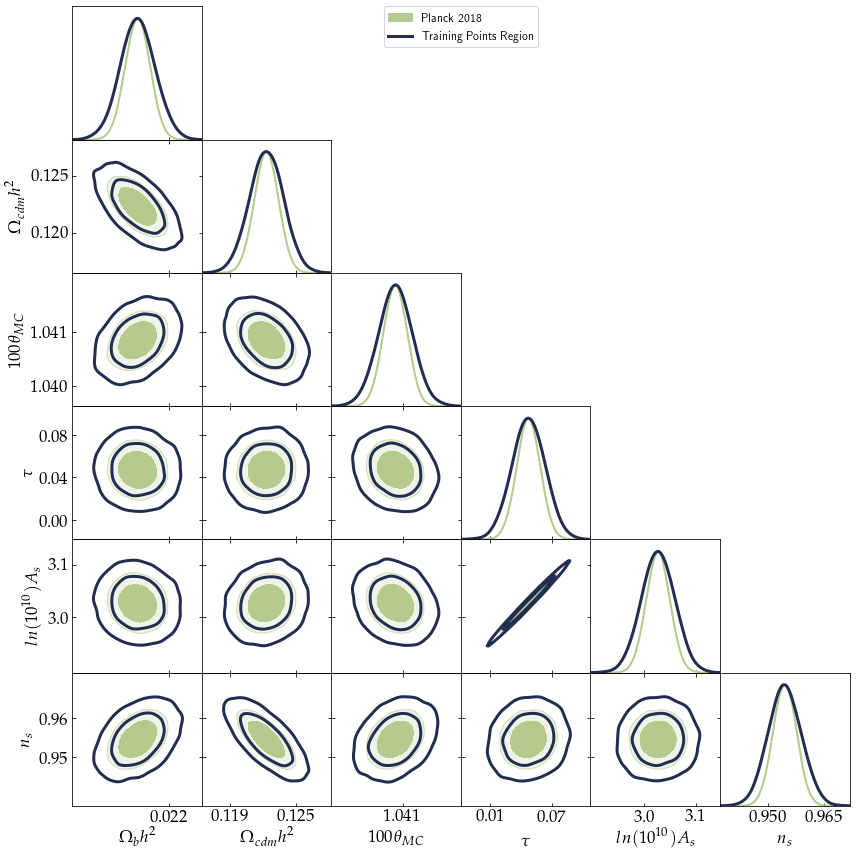

In [275]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_1, samples_2],
    filled=[True, False],
    contour_colors=[c1, c3],
    contour_lws=[2, 3],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Scale Training Points

In [225]:
def input_points_multivariate(cfg, priors):
    lhs_samples = pd.read_csv(f"lhs/samples_{NDIM}_{NLHS}.csv", index_col=0)
    dist = ss.norm(0, 1)
    scaled_samples = []
    for i in range(NDIM):
        scaled_samples.append(dist.ppf(lhs_samples.values[:, i]))
    scaled_samples = np.column_stack(scaled_samples)
    cholesky = np.linalg.cholesky(priors.cov)
    scaled = mean.reshape(NDIM, 1) + cholesky @ scaled_samples.T
    scaled = scaled.T
    return scaled

In [226]:
def input_points_uniform(cfg, priors):
    lhs_samples = pd.read_csv(f"lhs/samples_{NDIM}_{NLHS}.csv", index_col=0)
    scaled_samples = []
    for i, name in enumerate(cfg.cosmo.names):
        scaled_samples.append(priors[name].ppf(lhs_samples.values[:, i]))
    scaled_samples = np.column_stack(scaled_samples)
    return scaled_samples

In [227]:
def get_params(parameters: np.ndarray):

    params = {
        "ombh2": parameters[0],
        "omch2": parameters[1],
        "thetastar": parameters[2] / 100,
        "tau": parameters[3],
        "As": np.exp(parameters[4]) * 1e-10,
        "ns": parameters[5],
    }
    #'H0': parameters[4]}
    return params

In [228]:
def generate_cls(parameters: dict):

    pars = camb.CAMBparams()
    pars.set_cosmology(
        ombh2=parameters["ombh2"],
        omch2=parameters["omch2"],
        mnu=0.06,
        omk=0,
        tau=parameters["tau"],
        thetastar=parameters["thetastar"],
    )
    pars.InitPower.set_params(As=parameters["As"], ns=parameters["ns"])
    pars.set_for_lmax(2508, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

    # Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    # The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
    camb_tt = powers["unlensed_scalar"][:, 0]
    camb_ee = powers["unlensed_scalar"][:, 1]
    camb_bb = powers["unlensed_scalar"][:, 2]
    camb_te = powers["unlensed_scalar"][:, 3]

    ls = np.arange(camb_tt.shape[0])
    condition = (ls >= 2) & (ls <= 2508)

    powerspectra = {
        "ells": ls[condition],
        "tt": camb_tt[condition],
        "te": camb_te[condition],
        "ee": camb_ee[condition],
    }

    return powerspectra

In [229]:
def calculate_loglike(points):
    likelihood = PlanckLitePy(
        data_directory="data", year=2018, spectra="TTTEEE", use_low_ell_bins=False
    )
    # likelihood = PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)
    npoints = points.shape[0]
    record_logl = np.zeros(npoints)
    for i in range(npoints):
        parameters = get_params(points[i])
        cls = generate_cls(parameters)
        record_logl[i] = likelihood.loglike(
            cls["tt"], cls["te"], cls["ee"], min(cls["ells"])
        )
    return record_logl

In [230]:
if UNIFORM_PRIOR:
    cosmologies = input_points_uniform(cfg, priors)
else:
    cosmologies = input_points_multivariate(cfg, priors)

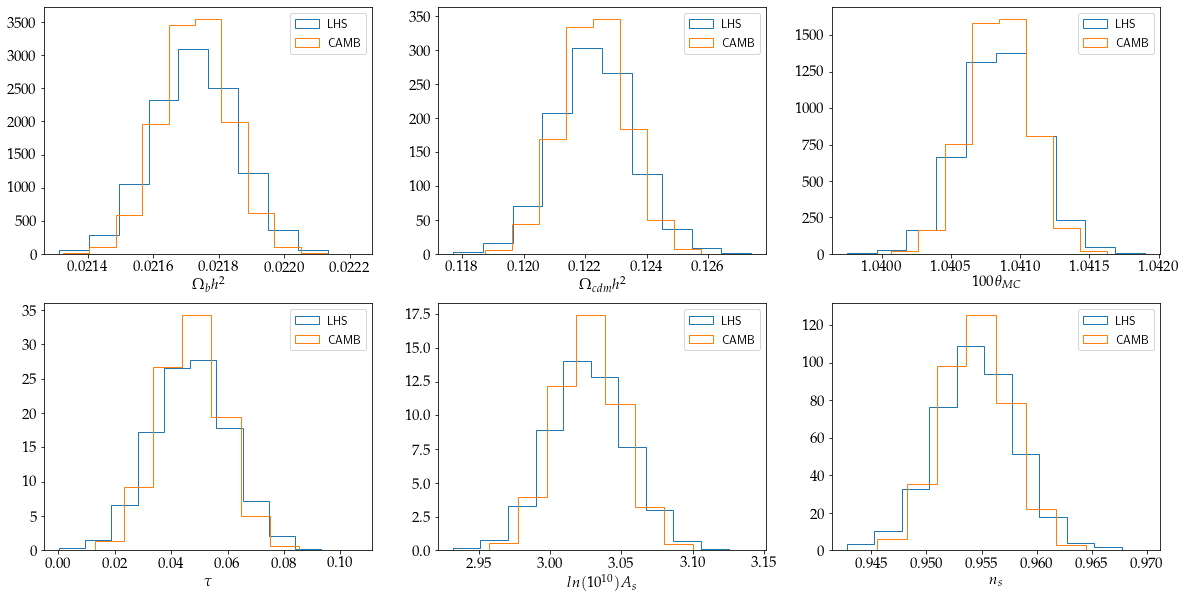

In [232]:
index = 0
plt.figure(figsize=(20, 10))
for index in range(6):
    plt.subplot(2, 3, index + 1)
    plt.hist(cosmologies[:, index], density=True, histtype="step", label="LHS")
    plt.hist(camb_samples_comb[:, index], density=True, histtype="step", label="CAMB")
    plt.xlabel(labels[index], fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.legend(loc="best", prop={"family": "sans-serif", "size": 12})
plt.show()

Calculate the log-likelihood. The first $d$ columns are the cosmological parameters and the last column is the loglikelihood. 

In [37]:
%%time
cosmo_likelihood = calculate_loglike(cosmologies)

CPU times: user 3h 23min 25s, sys: 8min 25s, total: 3h 31min 51s
Wall time: 26min 44s


In [38]:
%%time
calculate_loglike(mean.reshape(1, -1))

CPU times: user 6.22 s, sys: 584 ms, total: 6.81 s
Wall time: 869 ms


array([-614.42447087])

In [39]:
class transform_loglike:

    def __init__(self, loglikelihood):
        self.loglikelihood = loglikelihood
        self.dist = ss.norm(0, 1)
        self.ytrain = self.forward()

    def forward(self):
        log_chi2 = np.log(-2 * self.loglikelihood)
        # self.mean_log_chi2 = np.mean(log_chi2)
        # self.std_log_chi2 = np.std(log_chi2)
        # log_chi2_trans = (log_chi2 - self.mean_log_chi2) / self.std_log_chi2
        return log_chi2

    def inverse(self, prediction):
        # pred_trans = -np.exp(prediction * self.std_log_chi2 + self.mean_log_chi2)
        pred_trans = -0.5 * np.exp(prediction)
        return pred_trans

In [40]:
testing = transform_loglike(cosmo_likelihood)

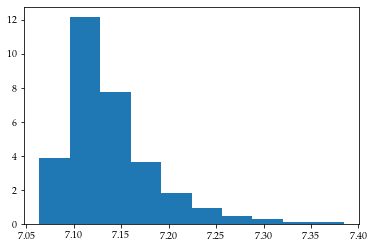

In [41]:
plt.hist(testing.ytrain, density=True)
plt.show()

In [42]:
class planckEmu:
    def __init__(self, cfg, inputs, loglike):
        self.cfg = cfg
        self.inputs = torch.from_numpy(inputs)
        self.ytrans = transform_loglike(loglike)
        self.outputs = torch.from_numpy(self.ytrans.ytrain)

        print("Training emulator")
        self.gp_module = self.train_gp()

    def train_gp(self):

        module = GaussianProcess(self.cfg, self.inputs, self.outputs, prewhiten=True)
        parameters = torch.randn(NDIM + 1)
        opt_params = module.optimisation(
            parameters,
            niter=self.cfg.emu.niter,
            lrate=self.cfg.emu.lr,
            nrestart=self.cfg.emu.nrestart,
        )
        return module

    def prediction(self, parameters):
        pred_gp = self.gp_module.prediction(torch.from_numpy(parameters))
        pred = self.ytrans.inverse(pred_gp.item())
        return pred

In [43]:
%%time
emulator = planckEmu(cfg, cosmologies, cosmo_likelihood)

Training emulator
CPU times: user 2h 4min 9s, sys: 8min 38s, total: 2h 12min 48s
Wall time: 16min 48s


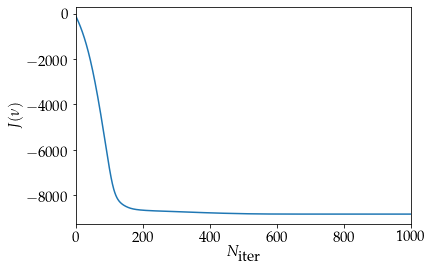

In [44]:
plt.plot(emulator.gp_module.d_opt["loss"])
plt.xlim(0, cfg.emu.niter)
plt.ylabel(r"$J(\nu)$", fontsize=fontSize)
plt.xlabel(r"$N_{\textrm{iter}}$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.show()

## Accuracy

In [45]:
%%time
gp_predictions = np.array(list(map(emulator.prediction, samples[0:NTEST])))

CPU times: user 388 ms, sys: 233 ms, total: 621 ms
Wall time: 204 ms


In [46]:
%%time
camb_predictions = calculate_loglike(samples[0:NTEST])

CPU times: user 1h 41min 41s, sys: 4min 13s, total: 1h 45min 54s
Wall time: 13min 22s


Planck

In [47]:
%%time
gp_predictions_planck = np.array(list(map(emulator.prediction, cosmoparams[0:NTEST])))

CPU times: user 316 ms, sys: 444 ms, total: 760 ms
Wall time: 208 ms


In [48]:
%%time
camb_predictions_planck = calculate_loglike(cosmoparams[0:NTEST])

CPU times: user 1h 50min 4s, sys: 4min 15s, total: 1h 54min 19s
Wall time: 15min 55s


In [49]:
fraction = (gp_predictions - camb_predictions) / camb_predictions
fraction_planck = (
    gp_predictions_planck - camb_predictions_planck
) / camb_predictions_planck

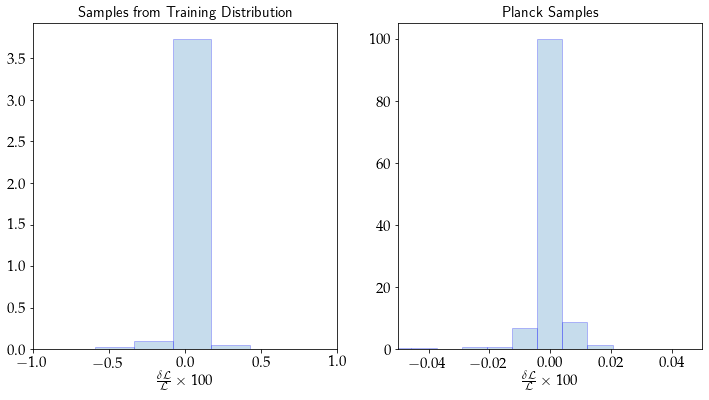

In [77]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Samples from Training Distribution", fontsize=fontSize)
plt.hist(fraction * 100, density=True, bins=20, edgecolor="b", alpha=0.25)
plt.xlabel(r"$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.xlim(-1.0, 1.0)
plt.subplot(122)
plt.title("Planck Samples", fontsize=fontSize)
plt.hist(fraction_planck * 100, density=True, bins=20, edgecolor="b", alpha=0.25)
plt.xlabel(r"$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.xlim(-0.05, 0.05)
plt.show()

# Optimisation

In [51]:
# params = torch.from_numpy(mean) + 1E-3 * torch.randn(5)
# lrate = 1E-3
# niter = 500

# # make sure we are differentiating with respect to the parameters
# params.requires_grad = True

# # initialise the optimiser
# optimiser = torch.optim.Adam([params], lr=lrate)

# loss = emulator.gp_module.prediction(params)

# # an empty list to store the loss
# record_loss = [loss.item()]

# # run the optimisation
# for _ in range(niter):
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     # evaluate the loss
#     loss = emulator.gp_module.prediction(params)

#     # record the loss at every step
#     record_loss.append(loss.item())

# 1D Distribution

In [52]:
def generate_pdf_camb(cfg, paramname, fiducial, npoints=25, returnemu: bool = False):

    if paramname == "ombh2":
        grid = np.linspace(0.015, 0.030, npoints)

    if paramname == "omch2":
        grid = np.linspace(0.10, 0.15, npoints)

    if paramname == "thetastar":
        grid = np.linspace(1.02, 1.06, npoints)

    if paramname == "ns":
        grid = np.linspace(0.90, 1.05, npoints)

    if paramname == "tau":
        grid = np.linspace(0.01, 0.10, npoints)

    if paramname == "As":
        grid = np.linspace(2.95, 3.15, npoints)

    idx = cfg.cosmo.names.index(paramname)
    points = np.tile(fiducial, (npoints, 1))
    points[:, idx] = grid
    camb_pred = calculate_loglike(points)
    if returnemu:
        gp_pred = np.array(list(map(emulator.prediction, points)))
        return grid, camb_pred, gp_pred
    return grid, camb_pred

In [233]:
# peakvalue = np.array([0.021851289403580783,
#  0.12134623401874374,
#  1.0414217039828337,
#  0.06139950550272463,
#  3.044965394612245,
#  0.95381224402205])

# ombh2 : -594.18
# omch2 : -590.59
# thetastar : -602.08
# tau : -586.56
# As : -587.43
# ns : -599.40

peakvalue = mean

# ombh2 : -604.38
# omch2 : -613.42
# thetastar : -613.21
# tau : -605.16
# As : -607.61
# ns : -606.77

In [234]:
record = {}
for name in cfg.cosmo.names:
    grid, camb_pred = generate_pdf_camb(
        cfg, name, peakvalue, npoints=25, returnemu=False
    )
    record[name] = {"grid": grid, "camb": camb_pred}

In [235]:
# pdf_gp = np.exp(gp_pred - max(gp_pred))
# pdf_camb = np.exp(camb_pred - max(camb_pred))

ombh2 : -581.31, 0.021250
omch2 : -581.59, 0.122917
thetastar : -585.15, 1.040000
tau : -580.37, 0.047500
As : -581.12, 3.025000
ns : -580.46, 0.950000


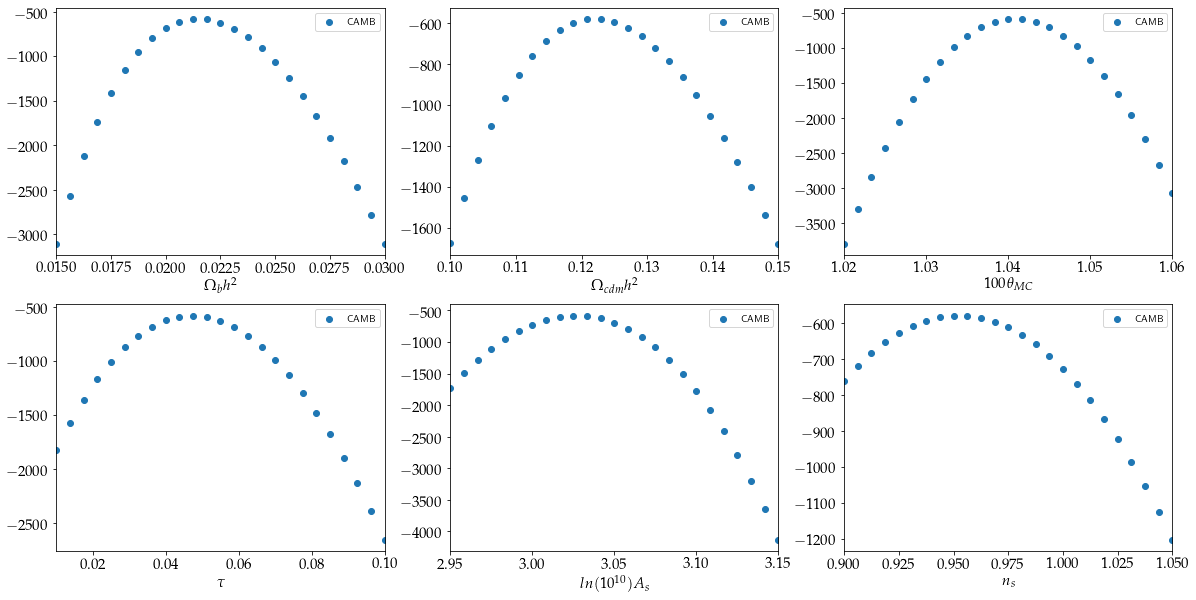

In [245]:
plt.figure(figsize=(20, 10))
for i, name in enumerate(cfg.cosmo.names):
    print(
        f'{name} : {max(record[name]["camb"]):.2f}, {record[name]["grid"][np.argmax(record[name]["camb"])].item():2f}'
    )
    plt.subplot(2, math.ceil(NDIM / 2), i + 1)
    # plt.scatter(record[name]['grid'], record[name]['gp'], label = 'Emulator')
    plt.scatter(record[name]["grid"], record[name]["camb"], label="CAMB")
    plt.xlim(min(record[name]["grid"]), max(record[name]["grid"]))
    plt.xlabel(labels[i], fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.legend()
plt.show()

# Sampling

In [57]:
def emcee_logprior_uniform(parameters):
    logp = 0.0
    for i, p in enumerate(priors):
        logp += priors[p].logpdf(parameters[i])
    return logp


def emcee_logprior_multivariate(parameters):
    logp = priors.logpdf(parameters)
    return logp


def emcee_loglike(parameters):
    if USE_GP:
        loglike = emulator.prediction(parameters)
    else:
        loglike = calculate_loglike(parameters.reshape(1, -1))
    return loglike

In [58]:
def emcee_logpost(parameters):
    loglike = emcee_loglike(parameters)
    if UNIFORM_PRIOR:
        logprior = emcee_logprior_uniform(parameters)
    else:
        logprior = emcee_logprior_multivariate(parameters)

    # we need the point to lie within the prior for emulation
    # this is because we are doing a zero mean GP.
    #     prior_value = np.exp(logprior)
    #     if prior_value < 1E-5 or not np.isfinite(prior_value):
    #         return -1E32
    logpost = loglike + logprior
    if np.isfinite(logpost):
        return logpost
    return -1e32

In [59]:
factor = 1e-4
nsamples_mcmc = 10000
pos = peakvalue + factor * np.random.normal(size=(2 * NDIM, NDIM))
nwalkers = pos.shape[0]

In [60]:
sampler = emcee.EnsembleSampler(nwalkers, NDIM, emcee_logpost)
sampler.run_mcmc(pos, nsamples_mcmc, progress=True)

100%|██████████| 10000/10000 [00:32<00:00, 309.96it/s]


In [61]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
flat_prob = sampler.get_log_prob(discard=1000, thin=15, flat=True)

In [62]:
maxpoint = flat_samples[np.argmax(flat_prob)]
minpoint = flat_samples[np.argmin(flat_prob)]

In [63]:
emulator.prediction(maxpoint)

-578.2139816277389

In [64]:
emulator.prediction(minpoint)

-587.7926831102458

In [72]:
calculate_loglike(mean.reshape(1, -1))

array([-614.42447087])

In [65]:
calculate_loglike(maxpoint.reshape(1, -1))

array([-579.65689829])

In [66]:
calculate_loglike(minpoint.reshape(1, -1))

array([-586.13324581])

In [67]:
for i in range(100):
    emu_like = emulator.prediction(flat_samples[i])
    sim_like = calculate_loglike(flat_samples[i].reshape(1, -1)).item()
    print(f"Simulator log-likelihood: {sim_like:.3f}")
    print(f"Emulator log-likelihood : {emu_like:.3f}")
    print(f"Difference in log-L     : {sim_like - emu_like:.3f}")
    print("-" * 75)

Simulator log-likelihood: -582.335
Emulator log-likelihood : -582.202
Difference in log-L     : -0.133
---------------------------------------------------------------------------
Simulator log-likelihood: -586.241
Emulator log-likelihood : -583.737
Difference in log-L     : -2.504
---------------------------------------------------------------------------
Simulator log-likelihood: -581.450
Emulator log-likelihood : -580.209
Difference in log-L     : -1.241
---------------------------------------------------------------------------
Simulator log-likelihood: -579.574
Emulator log-likelihood : -578.553
Difference in log-L     : -1.022
---------------------------------------------------------------------------
Simulator log-likelihood: -583.895
Emulator log-likelihood : -583.338
Difference in log-L     : -0.556
---------------------------------------------------------------------------
Simulator log-likelihood: -581.351
Emulator log-likelihood : -581.133
Difference in log-L     : -0.219
--

Simulator log-likelihood: -579.257
Emulator log-likelihood : -577.716
Difference in log-L     : -1.541
---------------------------------------------------------------------------
Simulator log-likelihood: -580.823
Emulator log-likelihood : -579.346
Difference in log-L     : -1.477
---------------------------------------------------------------------------
Simulator log-likelihood: -586.540
Emulator log-likelihood : -585.802
Difference in log-L     : -0.738
---------------------------------------------------------------------------
Simulator log-likelihood: -582.117
Emulator log-likelihood : -580.324
Difference in log-L     : -1.792
---------------------------------------------------------------------------
Simulator log-likelihood: -581.485
Emulator log-likelihood : -580.000
Difference in log-L     : -1.486
---------------------------------------------------------------------------
Simulator log-likelihood: -581.325
Emulator log-likelihood : -580.739
Difference in log-L     : -0.585
--

Simulator log-likelihood: -580.227
Emulator log-likelihood : -580.086
Difference in log-L     : -0.141
---------------------------------------------------------------------------
Simulator log-likelihood: -581.165
Emulator log-likelihood : -579.390
Difference in log-L     : -1.775
---------------------------------------------------------------------------
Simulator log-likelihood: -580.397
Emulator log-likelihood : -579.416
Difference in log-L     : -0.981
---------------------------------------------------------------------------
Simulator log-likelihood: -581.100
Emulator log-likelihood : -579.931
Difference in log-L     : -1.169
---------------------------------------------------------------------------
Simulator log-likelihood: -581.199
Emulator log-likelihood : -580.132
Difference in log-L     : -1.067
---------------------------------------------------------------------------
Simulator log-likelihood: -581.373
Emulator log-likelihood : -580.974
Difference in log-L     : -0.399
--

In [68]:
samples_3 = MCSamples(
    samples=flat_samples,
    names=names,
    labels=labels,
    settings=settings,
    label="Likelihood Emulator",
)

Removed no burn in


In [142]:
camb_samples_1 = np.loadtxt("samples/camb_samples_1.txt")
camb_samples_2 = np.loadtxt("samples/camb_samples_2.txt")

In [284]:
samples_gp = pickle_load("samples", "samples_GP_multivariate_2500_1")

In [285]:
samples_gp_thin = samples_gp.get_chain(discard=100, thin=2, flat=True)

In [288]:
samples_4 = MCSamples(
    samples=camb_samples_1, names=names, labels=labels, settings=settings, label="CAMB"
)
samples_5 = MCSamples(
    samples=samples_gp_thin,
    names=names,
    labels=labels,
    settings=settings,
    label="Emulator",
)

Removed no burn in
Removed no burn in


In [92]:
mean_chain = np.mean(flat_samples, axis=0)
std_chain = np.std(flat_samples, axis=0)

In [124]:
np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

In [125]:
np.around(mean_chain, 3)

array([0.022, 0.122, 1.041, 0.048, 3.030, 0.955])

In [126]:
np.around(std_chain * 1000, 3)

array([0.097, 1.006, 0.236, 8.321, 17.105, 2.892])

In [127]:
np.around(mean, 3)

array([0.022, 0.120, 1.041, 0.054, 3.045, 0.965])

In [129]:
np.around(std * 1000, 3)

array([0.151, 1.386, 0.312, 7.990, 16.135, 4.420])

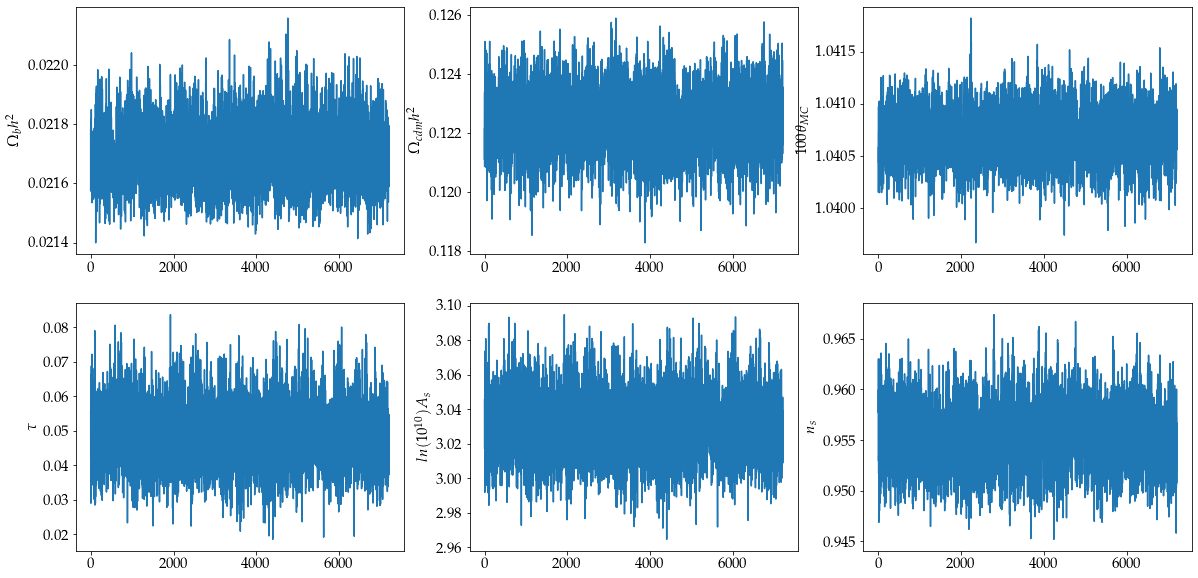

In [69]:
plt.figure(figsize=(20, 10))
for i, name in enumerate(cfg.cosmo.names):
    plt.subplot(2, 3, i + 1)
    plt.plot(flat_samples[:, i])
    plt.ylabel(labels[i], fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
plt.show()

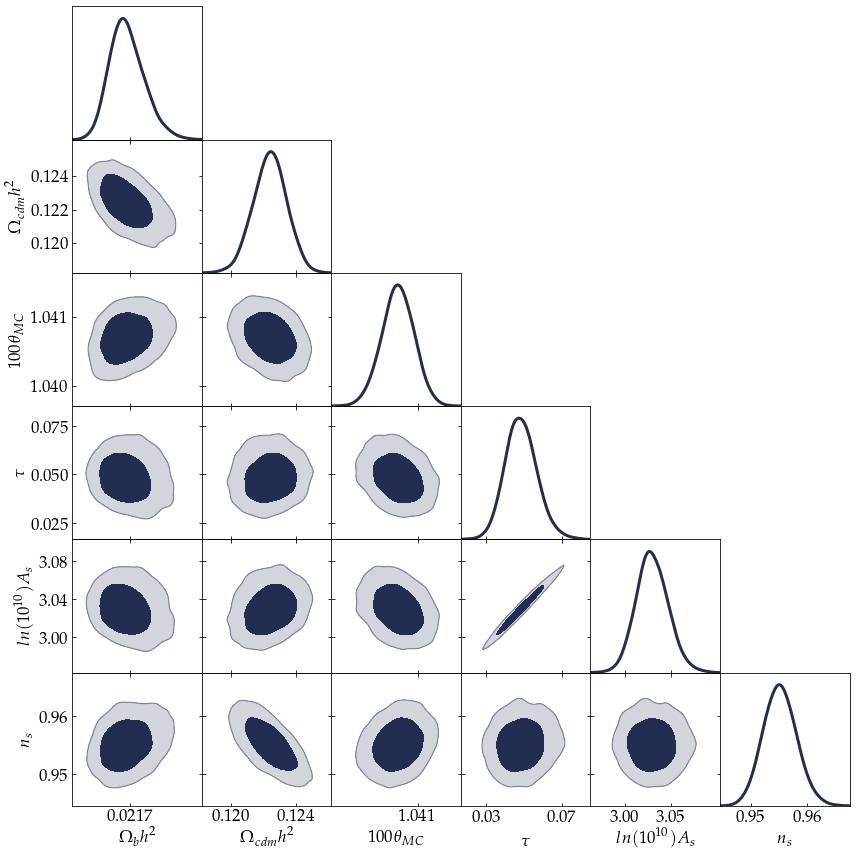

In [70]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_3.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(samples_3, filled=True, contour_colors=[c3], contour_lws=3)
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

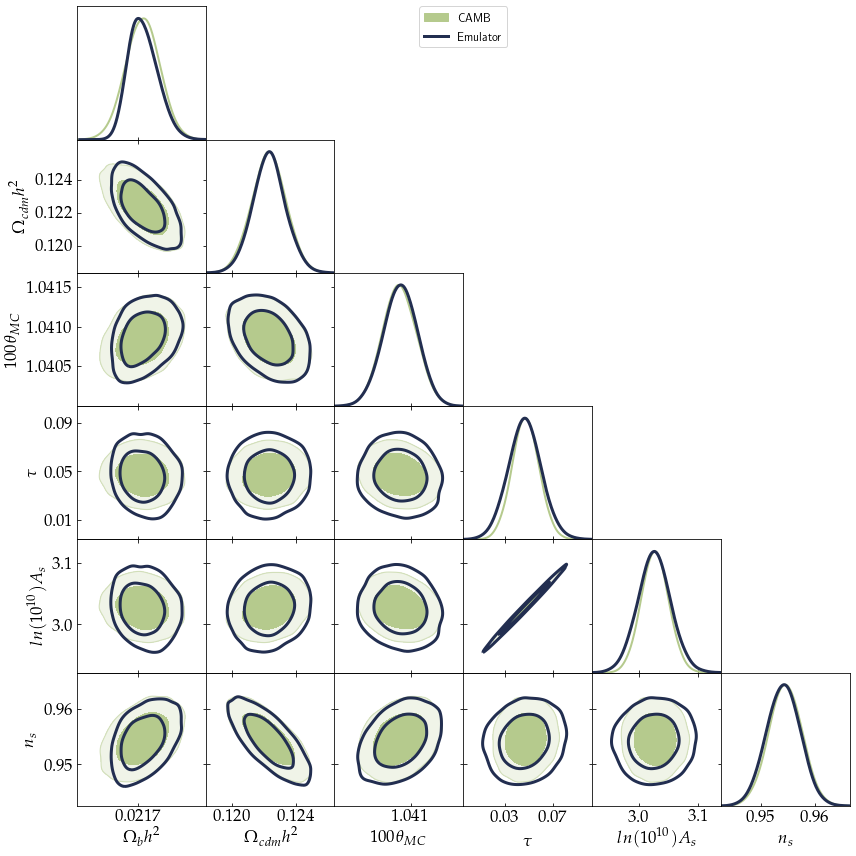

In [289]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_4, samples_5],
    filled=[True, False],
    contour_colors=[c1, c3],
    contour_lws=[2, 3],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [290]:
acc_2500 = pickle_load("accuracies", "acc_2500")

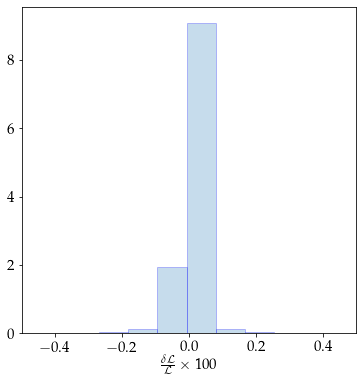

In [292]:
plt.figure(figsize=(6, 6))
plt.hist(acc_2500 * 100, density=True, bins=20, edgecolor="b", alpha=0.25)
plt.xlabel(r"$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.xlim(-0.5, 0.5)
plt.show()

# Samples with Neutrino

In [1]:
import numpy as np
import matplotlib.pylab as plt
from getdist import plots, MCSamples

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
contours = [0.68, 0.95]
linewidth = 2

In [2]:
camb_samples_1 = np.loadtxt("samples/camb_samples_uniform_neutrino_1.txt")

In [10]:
np.amin(camb_samples_1, axis=0)

array([ 0.02148501,  0.11698608,  1.03990617, -0.0073849 ,  2.91917519,
        0.93991335, -0.05998644])

In [6]:
labels = [
    r"$\Omega_{b}h^{2}$",
    r"$\Omega_{cdm}h^{2}$",
    r"$100\theta_{MC}$",
    r"$\tau$",
    r"$ln(10^{10})A_{s}$",
    r"$n_{s}$",
    r"$\sum m_{\nu}$",
]
names = ["x%s" % i for i in range(len(labels))]

In [7]:
samples_1 = MCSamples(
    samples=camb_samples_1,
    names=names,
    labels=labels,
    settings=settings,
    label="Planck",
)

Removed no burn in


In [8]:
c3 = "#222E50"
alpha = 0.7
contours = np.array([0.68, 0.95])

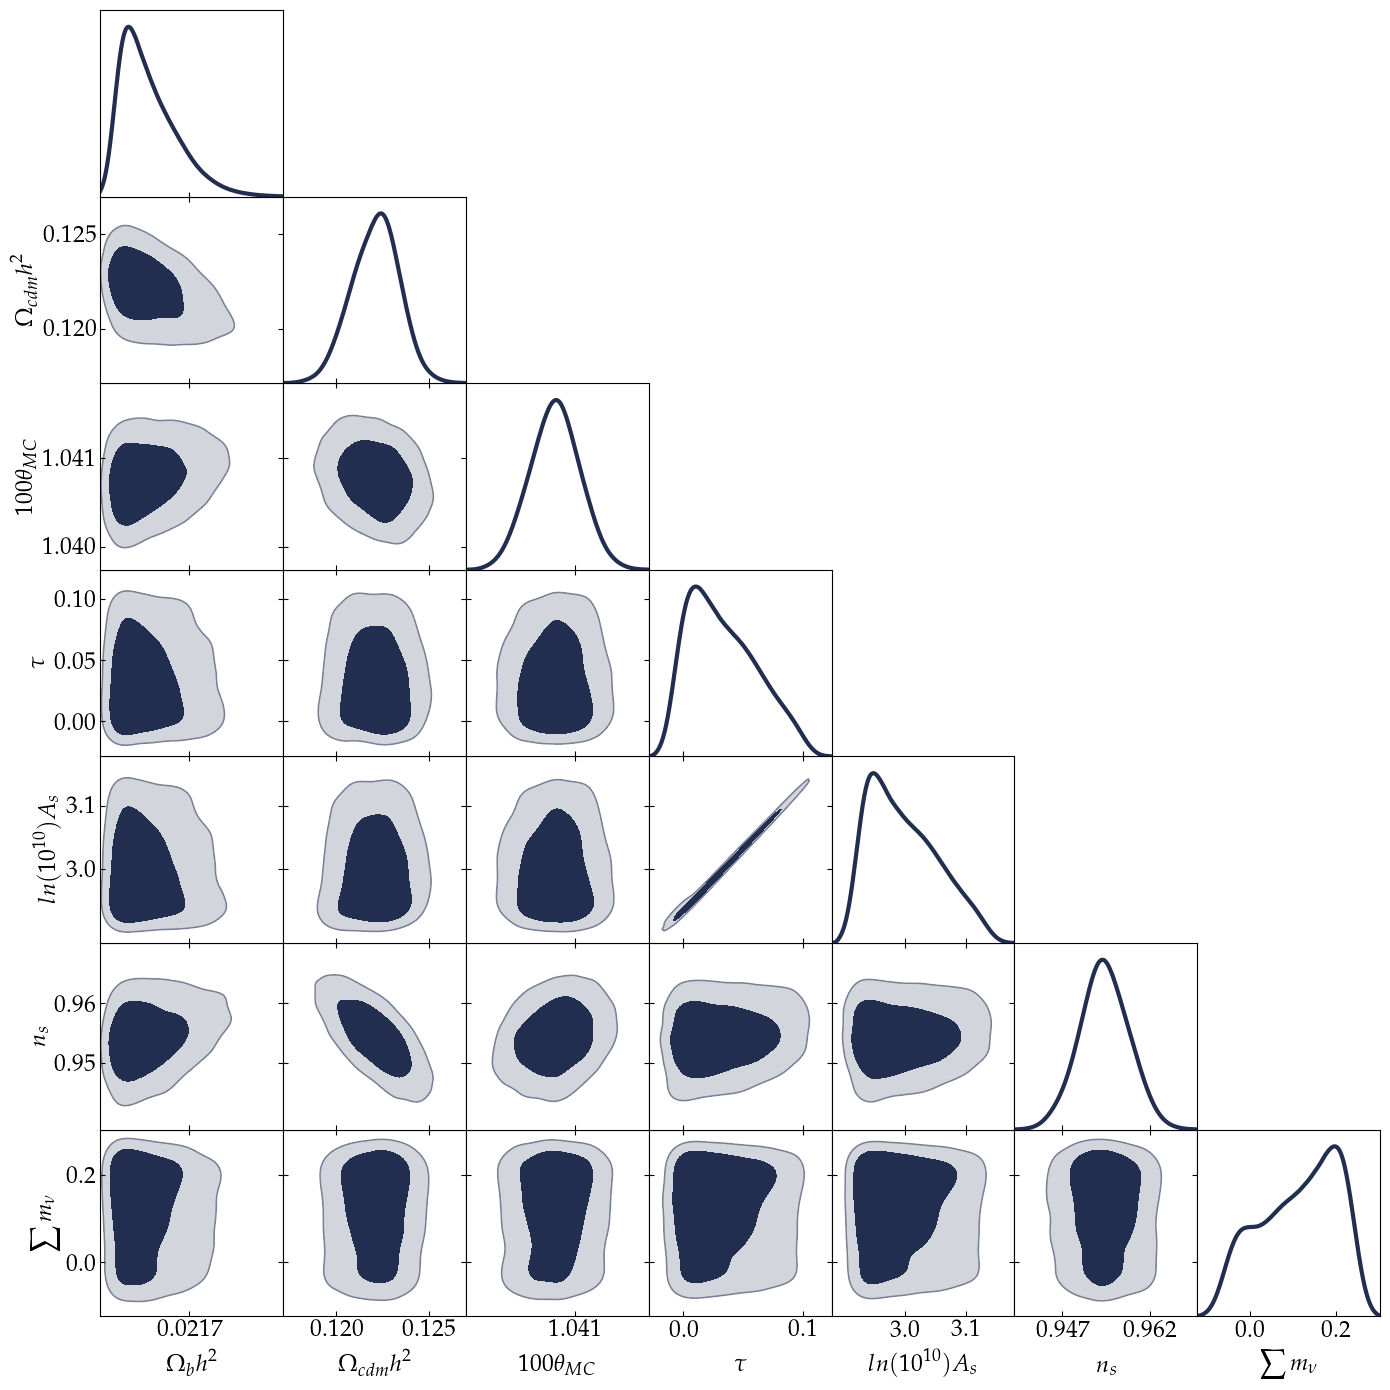

In [9]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(samples_1, filled=True, contour_colors=[c3], contour_lws=3)
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [11]:
from config import get_config
from src.sampling import generate_priors_uniform

In [12]:
cfg = get_config("planck")

In [17]:
cfg.sampling.std = 1e-3 * np.array([0.103, 1.046, 0.219, 11.078, 22.327, 3.022, 6.0])

In [18]:
testing = generate_priors_uniform(cfg)

# JLA

In [1]:
import glob
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
data_path = "experiments/jla/data/"

In [3]:
light_curve = pd.read_csv(data_path + "jla_lcparams.txt", sep=" ", header=0)

# sigma_mu
sigma_mu = np.loadtxt(data_path + "sigma_mu.txt")

# log stellar mass values
log_stellar_mass = light_curve["3rdvar"].values

# x1 values
x1 = light_curve["x1"].values

# color values
color = light_curve["color"].values

# redshift
redshifts = light_curve["zcmb"].values

# the "observed data
data = light_curve["mb"].values

In [4]:
inputs = {
    "mb": data,
    "ls": log_stellar_mass,
    "x1": x1,
    "c": color,
    "z": redshifts,
    "smu": sigma_mu,
}

In [5]:
from src.emulike.jla.config import get_config
from experiments.jla.jlalite import optimisation, loss_function, marginalise_nuisance

In [6]:
cfg = get_config("jla")

In [7]:
cfg.opt.initial

[0.12, 0.7, -19.0, 0.0, 0.125, 2.6]

In [8]:
# omch2, ombh2, h, w, Mb, delta_M, alpha, beta

# for the optimisation - we fix ombh2 and w
loss = loss_function(cfg.opt.initial, inputs, cfg)

In [9]:
loss

-1988.9421901335386

In [10]:
# soln, covariance = optimisation(cfg.opt.initial, inputs, cfg, save = False)

In [11]:
# newdata, newcov = marginalise_nuisance(inputs, cfg)

### Likelihood

In [2]:
from experiments.jla.jlalite import JLALitePy
from experiments.jla.params import Cosmology
from experiments.jla.model import jla_loglike
from src.emulike.jla.config import get_config
from utils.helpers import pickle_load

import numpy as np
import matplotlib.pylab as plt
from getdist import plots, MCSamples
import seaborn as sns
import pandas as pd

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"  #'#B5CA8D'
color3 = "#222E50"
alpha = 0.5
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

In [2]:
cfg = get_config("jla")
cosmo = Cosmology(omch2=0.12, ombh2=0.020, h=0.70)

In [3]:
JLAlike = JLALitePy(cfg)

In [4]:
JLAlike.loglike(cosmo)

-368.3051947777119

In [5]:
JLAlike.theory(cosmo)[0:10]

array([42.28810089, 42.66533784, 42.24466778, 41.3220942 , 43.07479589,
       42.79849482, 43.73290929, 41.20968512, 43.51365899, 41.99504869])

In [6]:
JLAlike.newdata[0:10]

array([41.96103121, 42.5287514 , 41.9473149 , 41.1763289 , 43.02537179,
       42.15252393, 43.33284421, 40.80812656, 43.34141882, 41.81337925])

# Priors

In [3]:
import numpy as np
import scipy.stats as ss

In [18]:
# sampling.mean = np.array([0.022, 0.15, 0.7])
# sampling.std = np.array([1e-3, 0.025, 0.05])

# sampling.mean = np.array([0.022, 0.12, 0.67, 3.05, 0.965])
# sampling.std = np.array([2e-4, 2e-3, 1e-2, 2e-2, 1e-2])

mu = 0.965
sigma = 0.025
xmin = mu - 5.0 * sigma
xmax = mu + 5.0 * sigma
xgrid = np.linspace(xmin, xmax, 1000)
pdf = ss.norm(mu, sigma).pdf(xgrid)

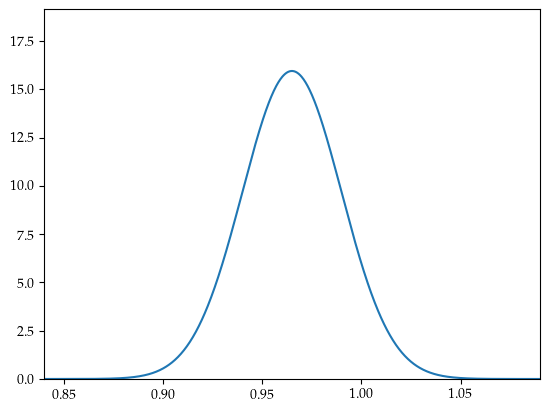

In [19]:
plt.plot(xgrid, pdf)
plt.xlim(xmin, xmax)
plt.ylim(0, 1.2 * max(pdf))
plt.show()

## Some Samples

In [7]:
jla_samples = pickle_load("src/emulike/jla/samples", "samples_lcdm_GP_700_emulator_1")

In [8]:
samples = jla_samples.get_chain(discard=500, thin=2, flat=True)  # jla_samples.flatchain

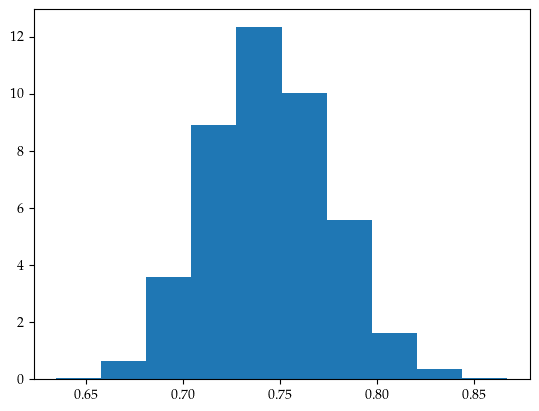

In [9]:
plt.hist(samples[:, 2], density=True)
plt.show()

## Accuracy JLA Emulator

In [42]:
acc_lcdm = pickle_load("src/emulike/jla/accuracies/", "acc_lcdm_700")
acc_wcdm = pickle_load("src/emulike/jla/accuracies/", "acc_wcdm_700")

In [43]:
acc_df_lcdm = pd.DataFrame(acc_lcdm * 100 * 1e4, columns=["Accuracy"])
acc_df_wcdm = pd.DataFrame(acc_wcdm * 100 * 1e4, columns=["Accuracy"])

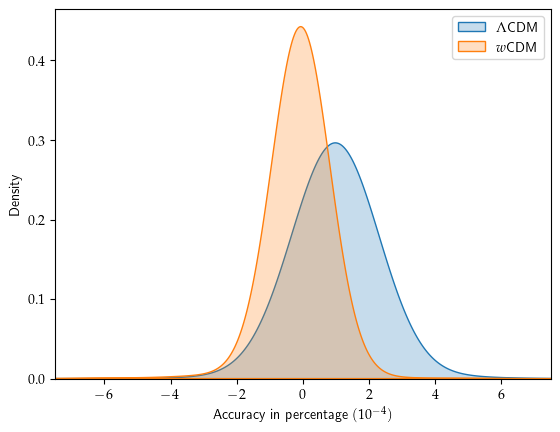

In [45]:
sns.kdeplot(
    data=acc_df_lcdm,
    x="Accuracy",
    bw_method=0.5,
    fill=True,
    gridsize=2000,
    label=r"$\Lambda$CDM",
)
sns.kdeplot(
    data=acc_df_wcdm,
    x="Accuracy",
    bw_method=0.5,
    fill=True,
    gridsize=2000,
    label=r"$w$CDM",
)
plt.xlabel(r"Accuracy in percentage $(10^{-4})$")
plt.xlim(-7.5, 7.5)
plt.legend()
plt.show()

## Triangle Plot

In [12]:
names = ["x%s" % i for i in range(3)]


# labels = [r'$\Omega_{b}h^{2}$',
#           r'$\Omega_{cdm}h^{2}$',
#           r'$h$',
#          r'$w$']

labels = [r"$\Omega_{b}h^{2}$", r"$\Omega_{cdm}h^{2}$", r"$h$"]

In [13]:
samples_1 = MCSamples(
    samples=samples, names=names, labels=labels, settings=settings, label="JLA"
)

Removed no burn in


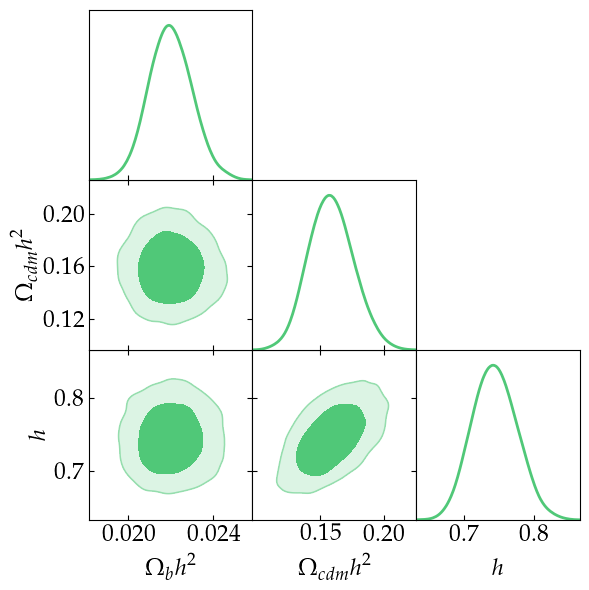

In [14]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
# samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot(
    samples_1, filled=[True], contour_colors=[color1], contour_lws=[2], contour_ls=["-"]
)
# plt.savefig('plots/triangle_plot_jla.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [1]:
from utils.helpers import pickle_load
from src.emulike.planck.config import get_config
from experiments.planck.plite import PlanckLitePy
from experiments.planck.model import planck_loglike

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from getdist import plots, MCSamples
import seaborn as sns

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"  #'#B5CA8D'
color3 = "#222E50"
alpha = 0.5
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

In [2]:
emu = pickle_load("src/emulike/planck/emulators/", "emulator_lcdm_1000")

cfg = get_config("planck")

likelihood = PlanckLitePy(
    data_directory=cfg.path.data,
    year=cfg.planck.year,
    spectra=cfg.planck.spectra,
    use_low_ell_bins=cfg.planck.use_low_ell_bins,
)

In [3]:
point = np.array([0.022, 0.12, 0.67, 3.05, 0.96])

In [4]:
%%time
emu.prediction(point)

CPU times: user 1.6 ms, sys: 938 µs, total: 2.54 ms
Wall time: 20.8 ms


-315.26522336937205

In [5]:
%%time
planck_loglike(likelihood, point, cfg)

{'ombh2': 0.022, 'omch2': 0.12, 'H0': 67.0, 'As': 2.111534442254061e-09, 'ns': 0.96}
CPU times: user 10.1 s, sys: 47.2 ms, total: 10.2 s
Wall time: 1.35 s


array([-315.26201207])

In [98]:
planck_samples = pickle_load(
    "src/emulike/planck/samples", "samples_lcdm_GP_1000_emulator_1"
)

In [99]:
samples = planck_samples.get_chain(discard=500, thin=2, flat=True)

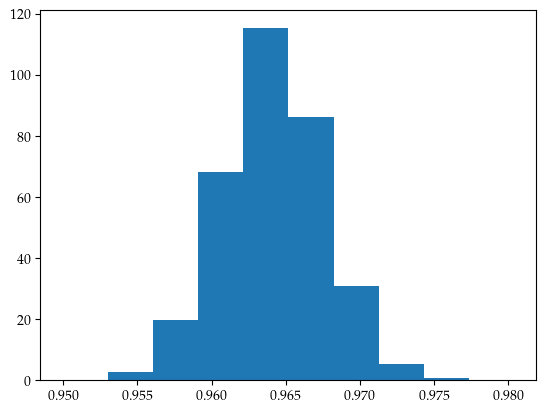

In [105]:
plt.hist(samples[:, 4], density=True)
plt.show()

# MOPED

## JLA

In [11]:
import numpy as np
from configs.JLAconfig import get_config as config_jla
from src.moped.jla.functions import JLAmoped, jla_moped_coefficients
from experiments.jla.params import Cosmology

In [12]:
cfg_jla = config_jla("jla")
cosmo = Cosmology(ombh2=0.022, omch2=0.12, h=0.7)
JLAcompression = JLAmoped(cfg_jla)

0 0 : 1.00000
1 0 : 0.00000
1 1 : 1.00000
2 0 : 0.00000
2 1 : -0.00000
2 2 : 1.00000


In [3]:
JLAcompression.compression(cosmo)

array([-272.30077637,  104.68365706, -263.29860547])

## Planck

In [1]:
from src.moped.planck.functions import PLANCKmoped
from configs.Planckconfig import get_config as config_planck
from experiments.planck.params import PCosmology

In [2]:
cfg_planck = config_planck("planck")

In [ ]:
PLANCKcompression = PLANCKmoped(cfg_planck)

In [3]:
params = PCosmology(ombh2=0.02, omch2=0.12, h=0.68, ln_10_10_As=3.045, ns=0.96)

In [4]:
PLANCKcompression.compression(params)

array([-129.89261005, -409.17624064,  297.72452009,  387.92831154,
          7.19535668])

## MOPED Likelihood

In [770]:
import os
import tqdm
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

from configs.Planckconfig import get_config as config_planck
from src.emulike.planck.distribution import planck_priors_normal, planck_logprior_normal
from src.moped.planck.functions import PLANCKmoped
from experiments.planck.model import planck_get_params
from utils.helpers import pickle_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

warnings.filterwarnings("ignore")

In [2]:
cfg_planck = config_planck("planck")

## Loglike

In [1260]:
from experiments.planck.model import planck_loglike
from experiments.planck.plite import PlanckLitePy

import gpytorch
import torch

POWER = 2

In [1261]:
class yTransformMoped:
    def __init__(self, values):
        self.values = torch.from_numpy(values)
        self.ymean, self.ystd, self.train_y = self.forward_transform(self.values)

    def forward_transform(self, values):
        """
        Implement a forward transformation if we want to.
        """
        ymean = torch.mean(values)
        ystd = torch.std(values)
        train_y = (values - ymean) / ystd
        train_y = train_y.to(torch.float32)
        return ymean, ystd, train_y

    def inverse_tranform(self, prediction):
        """
        Apply the inverse transformation on the predicted values.
        """
        pred_trans = prediction * self.ystd + self.ymean
        return pred_trans

class yTransformLogLike:
    def __init__(self, values):
        self.values = torch.from_numpy(values)
        self.ymean, self.ystd, self.train_y = self.forward_transform(self.values)

    def forward_transform(self, loglikes):
        """
        Implement a forward transformation if we want to.
        """
        values = torch.log(-2.0 * loglikes)
        ymean = torch.mean(values)
        ystd = torch.std(values)
        train_y = (values - ymean) / ystd
        train_y = train_y.to(torch.float32)
        return ymean, ystd, train_y

    def inverse_tranform(self, prediction):
        """
        Apply the inverse transformation on the predicted values.
        """
        pred_trans = prediction * self.ystd + self.ymean
        return -0.5*torch.exp(pred_trans)


class PreWhiten(object):
    def __init__(self, xinputs: torch.tensor):
        # compute the covariance of the inputs (ndim x ndim)
        self.cov_train = torch.cov(xinputs.t())
        self.ndim = xinputs.shape[1]

        # compute the Cholesky decomposition of the matrix
        self.chol_train = torch.linalg.cholesky(self.cov_train)

        # compute the mean of the sample
        self.mean_train = torch.mean(xinputs, axis=0).view(1, self.ndim)

    def x_transformation(self, point: torch.tensor) -> torch.tensor:
        """Pre-whiten the input parameters.

        Args:
            point (torch.tensor): the input parameters.

        Returns:
            torch.tensor: the pre-whitened parameters.
        """

        # ensure the point has the right dimensions
        point = point.view(-1, self.ndim)

        # calculate the transformed training points
        transformed = torch.linalg.inv(self.chol_train) @ (point - self.mean_train).t()

        return transformed.t()

class ExactGPModelAll(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelAll, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.initialize(constant=0.0)
        self.mean_module.constant.requires_grad = False
        kernel_1 = gpytorch.kernels.RBFKernel(ard_num_dims=5, active_dims=[0, 1, 2, 3, 4])
        kernel_2 = gpytorch.kernels.PolynomialKernel(num_dimensions = train_x.shape[1], 
                                                     power=POWER, 
                                                     active_dims = [0, 1, 2, 3, 4])
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel_1 + kernel_2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

   
class GPModel(PreWhiten):

    def __init__(self, inputs, yTransform):
        
        self.index = index 
        self.inputs = torch.from_numpy(inputs)
        self.yTransform = yTransform
        PreWhiten.__init__(self, self.inputs)
        
        self.train_x = PreWhiten.x_transformation(self, self.inputs)
        self.train_x = self.train_x.to(torch.float32)
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = ExactGPModelAll(self.train_x, self.yTransform.train_y, self.likelihood)

    def training(self, ntrain, lr = 0.1, noise = 1E-5, verbose = True):
        
        # Find optimal model hyperparameters
        self.model.train()
        self.likelihood.train()
        
        # Use the adam optimizer
        if noise is not None:
            self.model.likelihood.noise = noise
            training_parameters = [p for name, p in self.model.named_parameters()
                                   if not name.startswith('likelihood')]
        else:
            training_parameters = self.model.parameters()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adamax(training_parameters, lr=lr)  
        
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        record_loss = []
        with tqdm.trange(ntrain, disable=not verbose) as bar:
            for i in bar:
                optimizer.zero_grad()
                out = self.model(self.train_x)
                loss = -mll(out, self.yTransform.train_y)
                loss.backward()
                optimizer.step()
                            
                # display progress bar
                postfix = dict(Loss=f"{loss.item():.3f}", noise=f"{model.likelihood.noise.item():.3}")
                
                record_loss.append(loss.item())
                bar.set_postfix(postfix)
        return record_loss   

    def prediction(self, cosmology):
        # Get into evaluation (predictive posterior) mode
        self.model.eval()
        self.likelihood.eval()
        # add condition for MVN here 
        test_x = PreWhiten.x_transformation(self, cosmology).to(torch.float32)
       
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(test_x))
        
        return self.yTransform.inverse_tranform(observed_pred.mean)

    def sample(self, cosmology, nsamples = 1):
        self.model.eval()
        self.likelihood.eval()
        # add condition for MVN here 
        test_x = PreWhiten.x_transformation(self, cosmology).to(torch.float32)
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.likelihood(self.model(test_x))
        samples = torch.normal(observed_pred.mean.item(), observed_pred.stddev.item(), size = (nsamples,))
        return self.yTransform.inverse_tranform(samples)

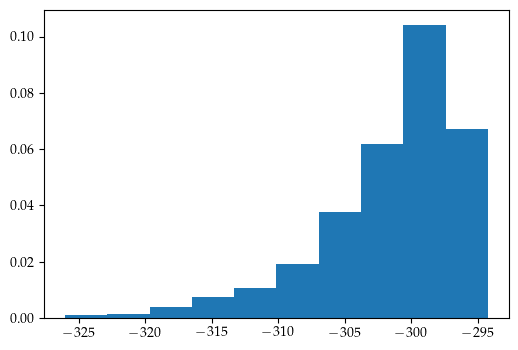

In [1262]:
loglike = pickle_load("src/emulike/planck/trainingpoints/", 'loglike_lcdm_1500')
cosmo_like = pickle_load('src/emulike/planck/trainingpoints/', 'cosmologies_lcdm_1500')

plt.figure(figsize = (6,4))
plt.hist(loglike, density = True)
plt.show()

In [1301]:
ytransformll = yTransformLogLike(loglike)
model_loglike = GPModel(cosmo_like, ytransformll)
loss_loglike = model_loglike.training(ntrain=200, lr = 0.1, noise = 1E-4, verbose=True)

100%|██████████████████████████████████████| 200/200 [00:41<00:00,  4.85it/s, Loss=-2.693, noise=0.00015]


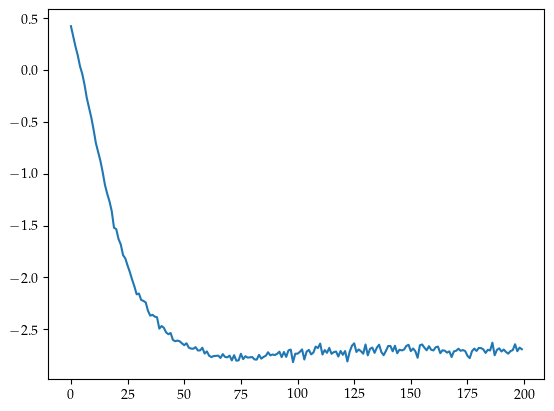

In [1302]:
plt.plot(loss_loglike)
plt.show()

In [1275]:
sim_samples = pickle_load('src/emulike/planck/samples/', 'samples_lcdm_CAMB_experiment_1').flatchain
sim_mean = np.mean(sim_samples, axis = 0)
sim_cov = np.cov(sim_samples.T)
mvn = multivariate_normal(sim_mean, cfg_planck.emu.ncov * sim_cov)
ntest = 100
testcosmo = mvn.rvs(ntest)
testcosmo_torch = torch.from_numpy(testcosmo)

In [1276]:
likelihood_planck = PlanckLitePy(
    data_directory=cfg_planck.path.data,
    year=cfg_planck.planck.year,
    spectra=cfg_planck.planck.spectra,
    use_low_ell_bins=cfg_planck.planck.use_low_ell_bins,
)

In [1277]:
sim_pred = planck_loglike(likelihood_planck, testcosmo, cfg_planck)

In [1278]:
loglike_pred = model_loglike.prediction(torch.from_numpy(testcosmo).to(torch.float32)).numpy()

In [1279]:
acc = (sim_pred - loglike_pred) / sim_pred * 100

In [1280]:
acc.mean()

0.0016172325797137361

In [1281]:
acc.std()

0.013525287046640203

In [1282]:
sim_pred[0:10]

array([-319.67961636, -304.39380304, -305.47540153, -308.11990946,
       -301.38198255, -303.58388176, -305.05998556, -305.21316502,
       -295.22369695, -295.89778651])

In [1283]:
loglike_pred[0:10]

array([-319.636  , -304.45624, -305.4762 , -308.06195, -301.42288,
       -303.62912, -305.00577, -305.17337, -295.21954, -295.8956 ],
      dtype=float32)

## MOPED

In [600]:
moped_coeffs = pickle_load("src/moped/planck/trainingpoints/", "moped_coefficients_lcdm_1500")
cosmologies = pickle_load("src/moped/planck/trainingpoints/", "cosmologies_lcdm_1500")

Mean : -96.14
Std  : 1.76
--------------------------------------------------
Mean : -406.97
Std  : 1.71
--------------------------------------------------
Mean : 301.57
Std  : 1.73
--------------------------------------------------
Mean : 388.19
Std  : 1.71
--------------------------------------------------
Mean : 9.58
Std  : 1.72
--------------------------------------------------


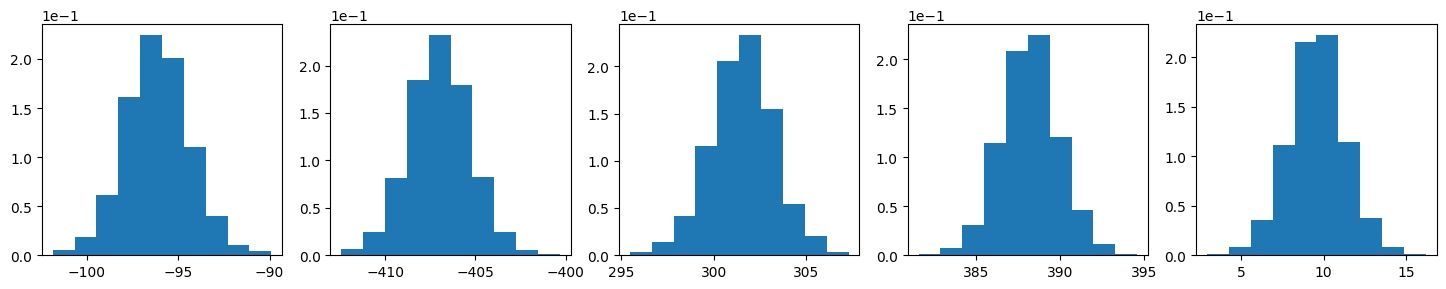

In [601]:
plt.figure(figsize = (18,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    mopedcoeff = moped_coeffs[:,i]
    print(f"Mean : {np.mean(mopedcoeff):.2f}")
    print(f"Std  : {np.std(mopedcoeff):.2f}")
    print('-'*50)
    plt.hist(moped_coeffs[:,i], density = True)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.show()

In [8]:
compressor = PLANCKmoped(cfg_planck)

0 0 : 1.00000
1 0 : 0.00000
1 1 : 1.00000
2 0 : -0.00000
2 1 : 0.00000
2 2 : 1.00000
3 0 : -0.00000
3 1 : 0.00000
3 2 : -0.00000
3 3 : 1.00000
4 0 : 0.00000
4 1 : -0.00000
4 2 : -0.00000
4 3 : -0.00000
4 4 : 1.00000


In [69]:
# model = "lcdm" if cfg_planck.lambdacdm else "wcdm"
# path_emu = os.path.join('src/moped/planck/', "emulators")
# emulators = {}
# for i in range(cfg_planck.ndim):
#     femu = f"emulator_{i}_{model}_{cfg_planck.emu.nlhs}"
#     emulators[i] = pickle_load(path_emu, femu)

### MOPED Coefficients as a function of parameters

In [16]:
def grid_moped(cfg, npoints=20, index = 0):

    sim_samples = pickle_load('src/emulike/planck/samples/', 'samples_lcdm_CAMB_experiment_1').flatchain
    parameter = np.mean(sim_samples, axis = 0)

    # ["ombh2", "omch2", "h", "As", "ns"]

    params_grid = np.repeat(parameter.reshape(-1,1), 20, axis = 1).T
    pmin = min(sim_samples[:,index])
    pmax = max(sim_samples[:,index])
    grid = np.linspace(pmin, pmax, npoints)
    params_grid[:,index] = grid

    record_moped = []
    for i in range(npoints):
        par = planck_get_params(params_grid[i], cfg)
        theory = compressor.compression(par)
        record_moped.append(theory)
    record_moped = np.array(record_moped)
    return grid, record_moped

In [ ]:
moped_ombh2 = grid_moped(cfg_planck, npoints=20, index=0)

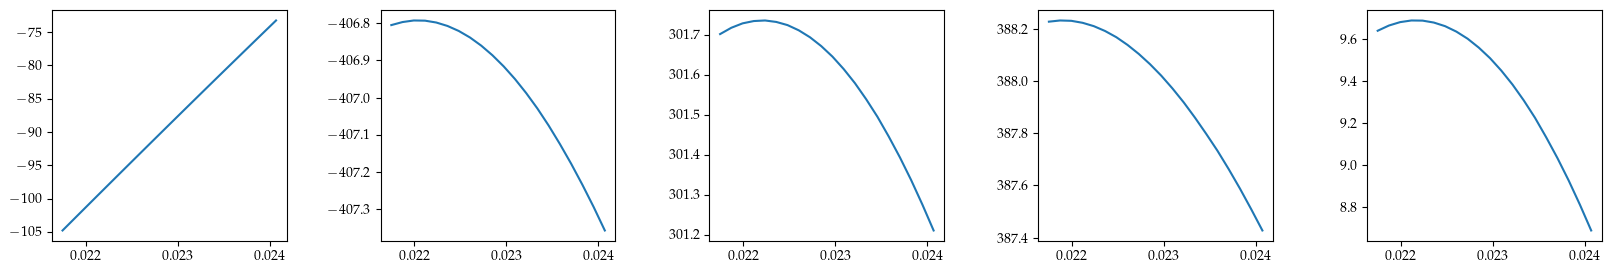

In [1151]:
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    plt.plot(moped_ombh2[0], moped_ombh2[1][:,i])
plt.subplots_adjust(wspace=0.4)
plt.show()

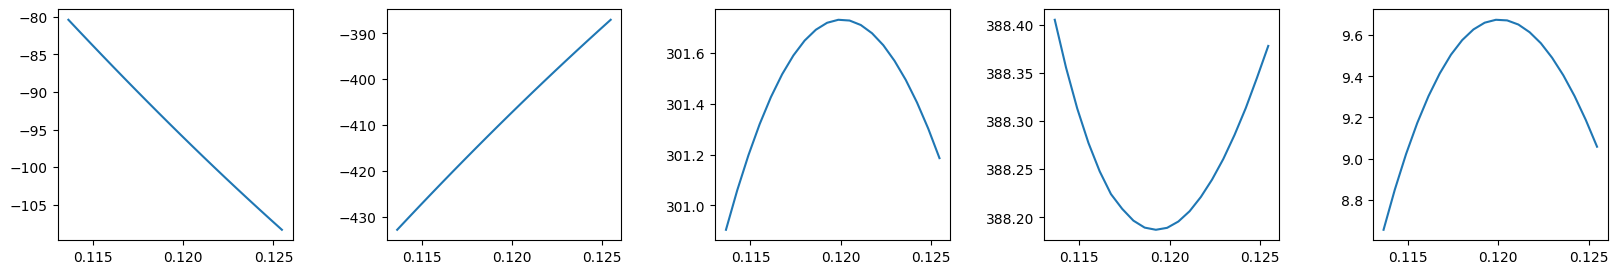

In [30]:
moped_omch2 = grid_moped(cfg_planck, npoints=20, index=1)
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    plt.plot(moped_omch2[0], moped_omch2[1][:,i])
plt.subplots_adjust(wspace=0.4)
plt.show()

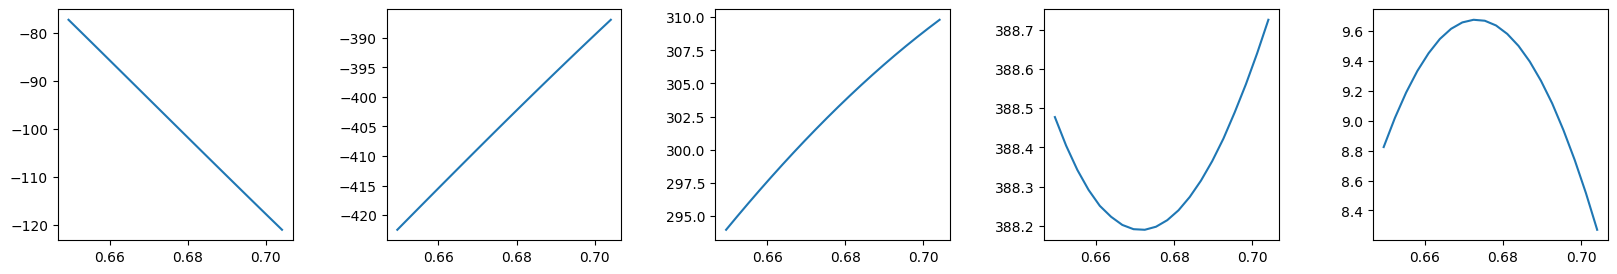

In [31]:
moped_h = grid_moped(cfg_planck, npoints=20, index=2)
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    plt.plot(moped_h[0], moped_h[1][:,i])
plt.subplots_adjust(wspace=0.4)
plt.show()

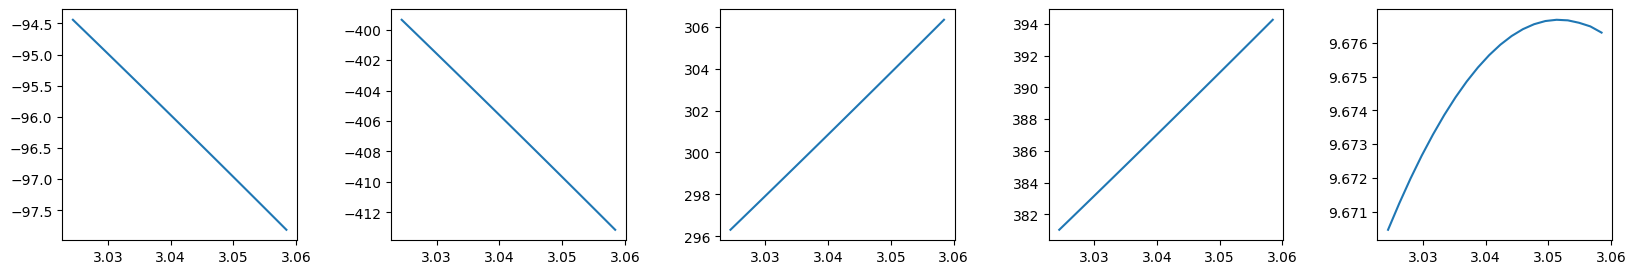

In [32]:
moped_as = grid_moped(cfg_planck, npoints=20, index=3)
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    plt.plot(moped_as[0], moped_as[1][:,i])
plt.subplots_adjust(wspace=0.4)
plt.show()

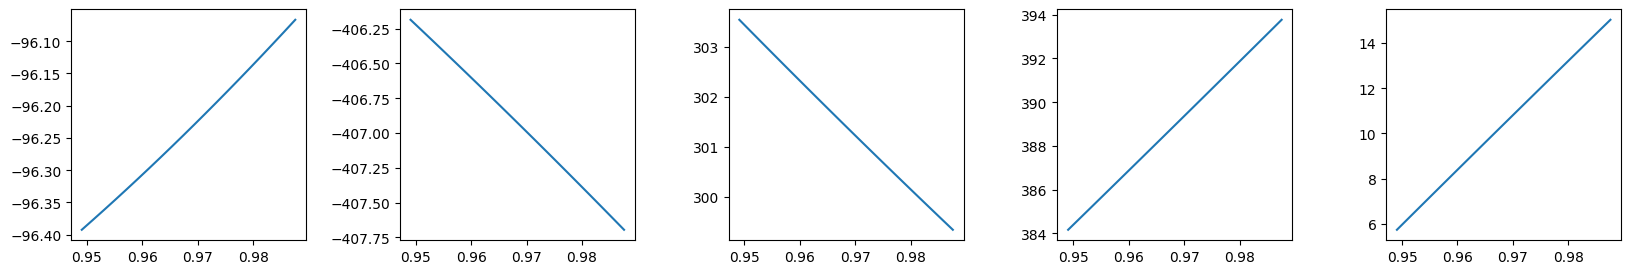

In [33]:
moped_ns = grid_moped(cfg_planck, npoints=20, index=4)
plt.figure(figsize = (20,3))
for i in range(5):
    plt.subplot(int(f'15{i+1}'))
    plt.plot(moped_ns[0], moped_ns[1][:,i])
plt.subplots_adjust(wspace=0.4)
plt.show()

# GPyTorch

In [1255]:
def moped_gp_models(cosmologies, moped_coeffs, ntrain = 200, lr = 0.1, noise = 1E-4, verbose = True):
    ndim = moped_coeffs.shape[1]
    models = {}
    loss = {}
    for i in range(ndim):
        ytransform = yTransformMoped(moped_coeffs[:,i])
        model = GPModel(cosmologies, ytransform)
        print(f'Training Model {i+1}')
        loss[i] = model.training(ntrain=ntrain, lr = lr, noise = noise, verbose=verbose)
        models[i] = model 
    return models, loss

In [1256]:
models, loss = moped_gp_models(cosmologies, moped_coeffs, lr = 0.5, noise = 1E-4)

Training Model 1


100%|██████████████████████████████████████| 200/200 [00:12<00:00, 16.54it/s, Loss=-3.585, noise=0.00015]


Training Model 2


100%|██████████████████████████████████████| 200/200 [00:12<00:00, 16.30it/s, Loss=-3.578, noise=0.00015]


Training Model 3


100%|██████████████████████████████████████| 200/200 [00:12<00:00, 16.21it/s, Loss=-3.578, noise=0.00015]


Training Model 4


100%|██████████████████████████████████████| 200/200 [00:12<00:00, 16.26it/s, Loss=-3.581, noise=0.00015]


Training Model 5


100%|██████████████████████████████████████| 200/200 [00:12<00:00, 16.25it/s, Loss=-3.584, noise=0.00015]


In [1257]:
models[0].sample(testcosmo_torch[0], nsamples = 10)

tensor([-94.8642, -94.8735, -94.8628, -94.8724, -94.8772, -94.8703, -94.8839,
        -94.8837, -94.8489, -94.8530])

In [1258]:
models[0].prediction(testcosmo_torch[0])

tensor([-94.8713])

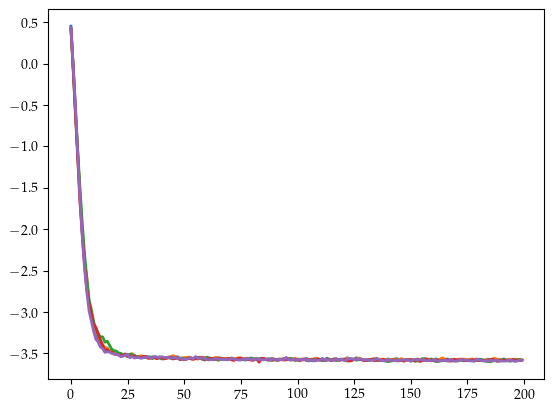

In [1259]:
plt.figure()
plt.plot(loss[0], lw = 2)
plt.plot(loss[1], lw = 2)
plt.plot(loss[2], lw = 2)
plt.plot(loss[3], lw = 2)
plt.plot(loss[4], lw = 2)
plt.show()

In [1284]:
ydata = compressor.store.ycomp

loglike_theory = np.zeros(ntest)
record = []
for i in range(ntest):
    par = planck_get_params(testcosmo[i], cfg_planck)
    exact = compressor.compression(par)
    loglike_theory[i] = -0.5*sum((ydata - exact)**2)
    record.append(exact)

record = np.asarray(record)

In [1285]:
predictions = torch.vstack([models[i].prediction(testcosmo_torch) for i in range(5)]).t()

In [1286]:
z_values = (record - predictions.numpy()) / record

In [1287]:
z_values.mean(0) * 100

array([ 0.00460959, -0.0006013 , -0.00033213,  0.00016004,  0.01349931])

In [1288]:
z_values.std(0) * 100

array([0.00652346, 0.00287991, 0.00120107, 0.00102038, 0.06402536])

## loglikelihood predictions

In [1291]:
loglike_gp = -0.5*np.sum((ydata - predictions.numpy())**2, axis = 1)

In [1292]:
z_value_loglike = (loglike_theory - loglike_gp) / loglike_theory

In [1293]:
z_value_loglike.mean() * 100

0.0030391444293215455

In [1294]:
z_value_loglike.std() * 100

0.2716227738332735

In [1295]:
z_loglike_df = pd.DataFrame(z_value_loglike*100, columns = ['Accuracy'])

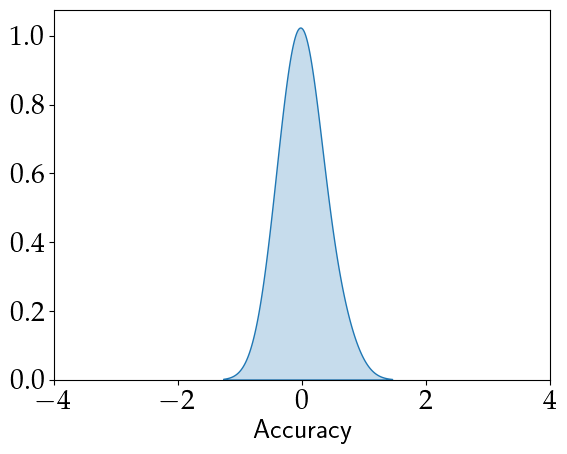

In [1296]:
sns.kdeplot(data=z_loglike_df, x="Accuracy", bw_method = 1.0, fill=True, gridsize=2000)
plt.xlabel(r'Accuracy', fontsize = fontSize)
plt.ylabel('', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-4, 4)
plt.show()

## Sampling with MOPED

In [1179]:
import emcee
from src.emulike.planck.distribution import planck_priors_normal, planck_logprior_normal

In [1180]:
priors = planck_priors_normal(cfg_planck)

In [1181]:
def planck_logpost_moped_sampler(vector, emulators, data, priors):
    vector = torch.from_numpy(vector).to(torch.float32)
    # either option
    # predictions = np.array([emulators[i].prediction(vector).item() for i in range(5)])
    predictions = np.array([emulators[i].sample(vector, nsamples = 1).item() for i in range(5)])
    logprior = planck_logprior_normal(vector.numpy(), priors)
    loglike = -0.5 * sum((predictions - data)**2)
    logpost = loglike + logprior
    if np.isfinite(logpost):
        return logpost.item()
    return -1e32

In [1182]:
pos = cfg_planck.sampling.mean + 1e-4 * np.random.normal(size=(2 * cfg_planck.ndim, cfg_planck.ndim))
nwalkers = pos.shape[0]

sampler = emcee.EnsembleSampler(
    nwalkers,
    cfg_planck.ndim,
    planck_logpost_moped_sampler,
    args=(models, ydata, priors),
)
sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████████████████████████████████████████████████████████| 10000/10000 [20:02<00:00,  8.31it/s]


State([[0.02247667 0.11987178 0.67619406 3.0409791  0.96639608]
 [0.02229839 0.12079543 0.66986057 3.04444542 0.96253666]
 [0.02217552 0.12127733 0.66658674 3.04351372 0.96116711]
 [0.02220747 0.12123977 0.66831821 3.04542468 0.96431412]
 [0.02210466 0.12224129 0.66148711 3.04776273 0.9608896 ]
 [0.02222863 0.12032942 0.67123204 3.04497381 0.96551731]
 [0.02239088 0.12086763 0.67226846 3.04502425 0.96601993]
 [0.0226226  0.11840913 0.68163417 3.03861178 0.97423769]
 [0.0224438  0.12068834 0.67124026 3.04526705 0.96171771]
 [0.0223837  0.11941149 0.67518062 3.04065291 0.9653309 ]], log_prob=[13.32427553 15.41289236 14.04910526 14.24682324 13.10332424 13.85526996
 13.12688322 12.05994734 14.70152123 15.10687266], blobs=None, random_state=('MT19937', array([1279556330, 1664022253, 1267522490, 2219478831,  636638108,
        801042239,  498882947, 2210504828, 4247539921, 3801258639,
       3069524206,  839929547, 3478001345, 4104041410,  662525230,
       2223927142,   99917368,  116767425

In [1183]:
simulator = pickle_load('src/emulike/planck/samples/', 'samples_lcdm_CAMB_experiment_1')

In [1184]:
samples_simulator = simulator.get_chain(discard = 1000, flat = True)
samples_moped = sampler.get_chain(discard = 100, flat = True)

In [1185]:
from getdist import plots, MCSamples

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878'
color2 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [1186]:
NDIM = samples_simulator.shape[1]
names = ["x%s"%i for i in range(NDIM)]
labels = [r'$\Omega_{b}h^{2}$', 
          r'$\Omega_{cdm}h^{2}$', 
          r'$h$', 
          r'$ln(10^{10}A_{s})$', 
          r'$n_{s}$']

samples_1 = MCSamples(samples=samples_simulator,names = names, labels = labels, settings = settings, label = 'CAMB')
samples_2 = MCSamples(samples=samples_moped,names = names, labels = labels, settings = settings, label = 'Emulator - MOPED')

Removed no burn in
Removed no burn in


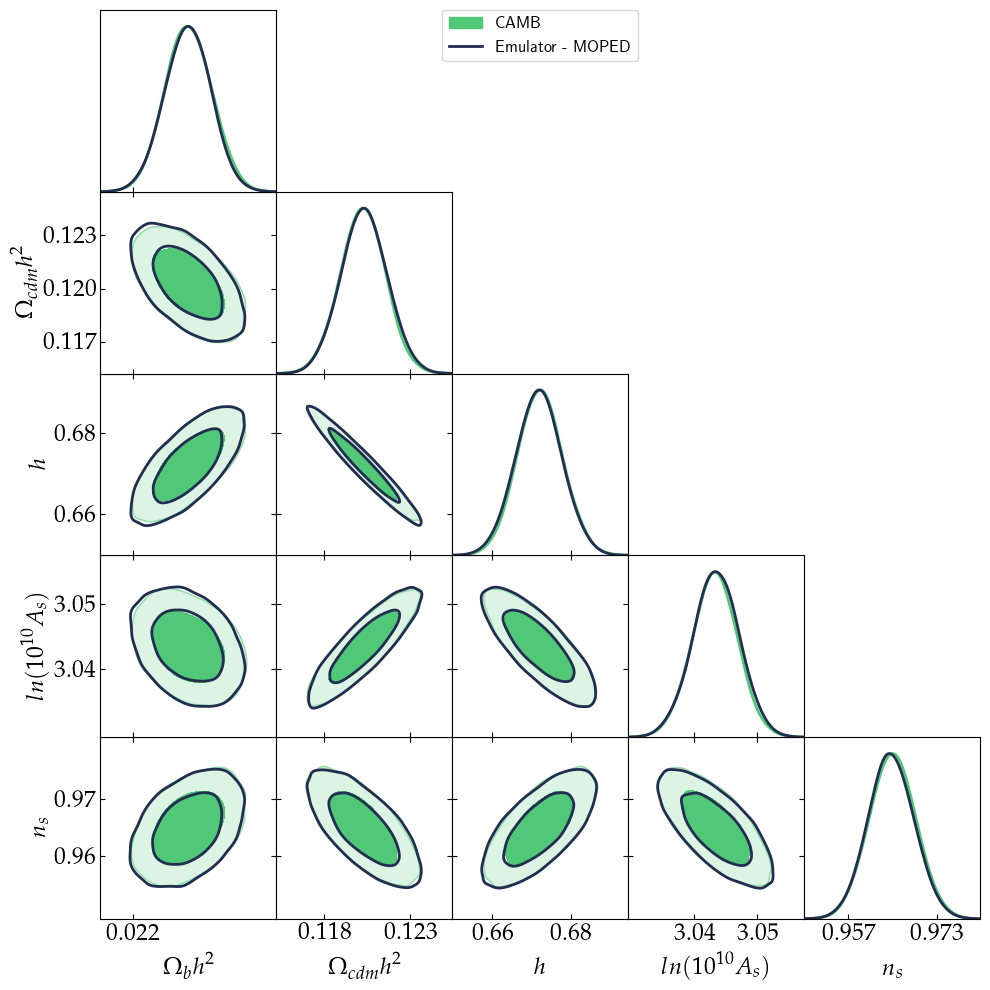

In [1187]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True, False], contour_colors=[color1, color2], contour_lws=[2,2], contour_ls=['-','-'])
# plt.savefig('plots/triangle_plot_uniform_accurate.pdf', transparent = False, bbox_inches = 'tight') 
# plt.savefig('plots/triangle_plot_uniform_accurate.png', transparent = False, bbox_inches = 'tight') 
plt.show()